In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_537227/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


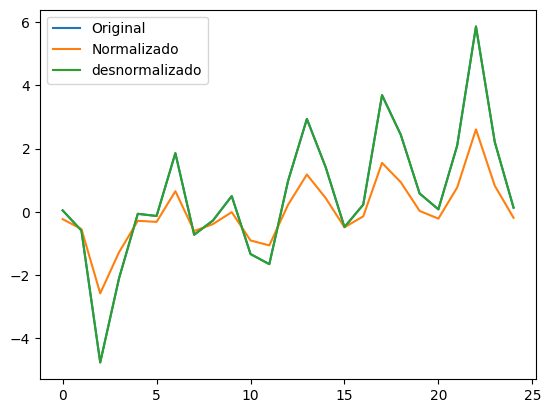

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 6.60 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-02 19:27:47.736172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 19:27:47.736241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 19:27:47.737938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 19:27:47.748552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-09-02 19:27:51.114922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  14


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


 1/32 [..............................] - ETA: 1s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  17
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  19
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  45
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.954541,0.792903,0.694999,0.971686,0.204774,1.384861,1.090971,0.174110,1.096771,0.452520,1.376659,0.460390,133.171697,268.211631
model_1_1_8,0.953674,0.792884,0.693595,0.971095,0.208679,1.384983,1.095992,0.177745,1.105729,0.456814,1.383842,0.464759,133.133920,268.173853
model_1_1_7,0.952752,0.792424,0.692535,0.970354,0.212834,1.388062,1.099786,0.182301,1.115974,0.461340,1.391486,0.469364,133.094483,268.134416
model_1_1_6,0.950766,0.791474,0.690012,0.968782,0.221778,1.394417,1.108809,0.191968,1.138142,0.470933,1.407937,0.479124,133.012155,268.052088
model_1_1_5,0.949750,0.790931,0.688701,0.967850,0.226358,1.398046,1.113497,0.197702,1.148672,0.475770,1.416360,0.484045,132.971279,268.011213
model_1_1_4,0.948740,0.790439,0.687268,0.966949,0.230905,1.401333,1.118625,0.203242,1.159597,0.480526,1.424725,0.488883,132.931497,267.971431
model_1_1_3,0.939879,0.786816,0.674959,0.959046,0.270820,1.425566,1.162651,0.251838,1.245730,0.520404,1.498144,0.529455,132.612603,267.652537
model_1_1_2,0.938689,0.786223,0.673751,0.957701,0.276180,1.429525,1.166974,0.260110,1.255617,0.525528,1.508003,0.534668,132.573406,267.613340
model_1_1_1,0.936174,0.784959,0.670839,0.955294,0.287512,1.437979,1.177391,0.274911,1.278581,0.536202,1.528847,0.545528,132.492980,267.532913
model_1_1_0,0.930181,0.779782,0.671483,0.940952,0.314508,1.472601,1.175087,0.363107,1.283969,0.560810,1.578503,0.570564,132.313491,267.353425


DataFrame salvo em ../results/metrics_1_1


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.968132,0.800446,0.720665,0.963983,0.143555,1.334418,0.999166,0.179619,0.911279,0.378886,1.264053,0.385476,133.882080,268.922014
model_1_2_8,0.967550,0.800107,0.719379,0.963523,0.146176,1.336687,1.003767,0.181914,0.919752,0.382329,1.268874,0.388979,133.845894,268.885827
model_1_2_7,0.966968,0.799657,0.718034,0.963057,0.148795,1.339698,1.008577,0.184236,0.927244,0.385739,1.273691,0.392448,133.810378,268.850312
model_1_2_6,0.966364,0.799265,0.716669,0.962601,0.151518,1.342314,1.013460,0.186513,0.935785,0.389253,1.278700,0.396023,133.774108,268.814042
model_1_2_5,0.965708,0.798887,0.715090,0.962046,0.154471,1.344840,1.019108,0.189280,0.944641,0.393028,1.284133,0.399864,133.735493,268.775427
model_1_2_4,0.960343,0.796492,0.706508,0.956921,0.178641,1.360856,1.049802,0.214836,1.024016,0.422659,1.328590,0.430010,133.444755,268.484689
model_1_2_3,0.959644,0.796102,0.705101,0.956423,0.181786,1.363470,1.054838,0.217318,1.033020,0.426363,1.334375,0.433779,133.409855,268.449789
model_1_2_2,0.958194,0.795249,0.702189,0.955311,0.188318,1.369171,1.065254,0.222868,1.051226,0.433956,1.346391,0.441504,133.339245,268.379179
model_1_2_1,0.957536,0.794880,0.700909,0.954898,0.191284,1.371637,1.069833,0.224924,1.058017,0.437360,1.351845,0.444967,133.307996,268.347930
model_1_2_0,0.955343,0.793357,0.696625,0.953505,0.201162,1.381825,1.085156,0.231874,1.086683,0.448511,1.370016,0.456312,133.207288,268.247222


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.980072,0.811462,0.751388,0.985629,0.089766,1.260753,0.889270,0.091190,0.597193,0.299609,1.165114,0.304820,134.821104,269.861038
model_1_3_8,0.979753,0.811280,0.750895,0.985554,0.091205,1.261971,0.891034,0.091662,0.596897,0.302002,1.167762,0.307254,134.789292,269.829226
model_1_3_7,0.979377,0.811248,0.750316,0.985342,0.092897,1.262188,0.893106,0.093011,0.594205,0.304790,1.170874,0.310091,134.752529,269.792463
model_1_3_6,0.978560,0.811151,0.748896,0.984775,0.096580,1.262832,0.898183,0.096611,0.589598,0.310774,1.177649,0.316179,134.674760,269.714694
model_1_3_5,0.978187,0.810991,0.748222,0.984618,0.098259,1.263901,0.900594,0.097603,0.588064,0.313463,1.180736,0.318915,134.640301,269.680235
model_1_3_4,0.977791,0.810827,0.747534,0.984422,0.100044,1.264998,0.903055,0.098851,0.585963,0.316298,1.184020,0.321799,134.604287,269.644221
model_1_3_3,0.977383,0.810756,0.746628,0.984142,0.101880,1.265474,0.906295,0.100625,0.581657,0.319187,1.187398,0.324739,134.567910,269.607844
model_1_3_2,0.976990,0.810530,0.745838,0.983863,0.103649,1.266986,0.909123,0.102392,0.580243,0.321945,1.190651,0.327545,134.533496,269.573430
model_1_3_1,0.976049,0.810276,0.743977,0.983188,0.107892,1.268683,0.915781,0.106676,0.581253,0.328469,1.198455,0.334182,134.453253,269.493187
model_1_3_0,0.975496,0.809483,0.741583,0.983242,0.110382,1.273987,0.924343,0.106335,0.609090,0.332238,1.203035,0.338016,134.407619,269.447553


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  24
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 1s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.988634,0.814038,0.772051,0.993456,0.051200,1.243531,0.815361,0.022482,0.455204,0.226274,1.094176,0.230209,135.944041,270.983975
model_1_4_8,0.988421,0.813962,0.771701,0.993390,0.052160,1.244035,0.816614,0.022711,0.459266,0.228385,1.095942,0.232357,135.906895,270.946828
model_1_4_7,0.988204,0.813889,0.771346,0.993317,0.053138,1.244526,0.817884,0.022960,0.463221,0.230517,1.097742,0.234526,135.869719,270.909653
model_1_4_6,0.987978,0.813807,0.770938,0.993233,0.054154,1.245075,0.819342,0.023248,0.467231,0.232710,1.099610,0.236757,135.831853,270.871787
model_1_4_5,0.987750,0.813739,0.770593,0.993156,0.055181,1.245526,0.820577,0.023514,0.471352,0.234907,1.101500,0.238993,135.794264,270.834198
model_1_4_4,0.987516,0.813657,0.770176,0.993068,0.056237,1.246073,0.822066,0.023815,0.475570,0.237143,1.103441,0.241267,135.756373,270.796306
model_1_4_3,0.987282,0.813583,0.769790,0.992995,0.057288,1.246572,0.823448,0.024065,0.479610,0.239350,1.105376,0.243513,135.719312,270.759245
model_1_4_2,0.987033,0.813479,0.769269,0.992886,0.058411,1.247268,0.825310,0.024442,0.483984,0.241683,1.107440,0.245887,135.680509,270.720443
model_1_4_1,0.986786,0.813403,0.768865,0.992793,0.059522,1.247775,0.826758,0.024762,0.487993,0.243971,1.109484,0.248214,135.642824,270.682758
model_1_4_0,0.986541,0.813331,0.768513,0.992707,0.060626,1.248258,0.828017,0.025056,0.492064,0.246223,1.111514,0.250505,135.606071,270.646005


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.990630,0.815635,0.775748,0.995791,0.042210,1.232849,0.802138,0.025664,0.412664,0.205451,1.077641,0.209024,136.330195,271.370128
model_1_5_8,0.990450,0.815513,0.775248,0.995753,0.043019,1.233665,0.803924,0.025895,0.416683,0.207410,1.079129,0.211018,136.292225,271.332159
model_1_5_7,0.990271,0.815366,0.774977,0.995705,0.043824,1.234651,0.804894,0.026189,0.420462,0.209342,1.080609,0.212983,136.255148,271.295081
model_1_5_6,0.990084,0.815221,0.774692,0.995645,0.044667,1.235618,0.805914,0.026554,0.424358,0.211346,1.082161,0.215022,136.217028,271.256962
model_1_5_5,0.989890,0.815073,0.774387,0.995582,0.045543,1.236609,0.807003,0.026941,0.428298,0.213408,1.083771,0.217120,136.178194,271.218128
model_1_5_4,0.989694,0.814912,0.774020,0.995523,0.046425,1.237682,0.808317,0.027299,0.432262,0.215465,1.085394,0.219213,136.139822,271.179756
model_1_5_3,0.989486,0.814751,0.773676,0.995445,0.047360,1.238758,0.809547,0.027775,0.436563,0.217623,1.087113,0.221408,136.099961,271.139895
model_1_5_2,0.989276,0.814595,0.773282,0.995366,0.048306,1.239807,0.810955,0.028257,0.440841,0.219787,1.088854,0.223610,136.060383,271.100317
model_1_5_1,0.989064,0.814411,0.772851,0.995297,0.049263,1.241036,0.812500,0.028676,0.445551,0.221953,1.090614,0.225813,136.021165,271.061099
model_1_5_0,0.988851,0.814225,0.772440,0.995220,0.050220,1.242277,0.813970,0.029145,0.450268,0.224098,1.092374,0.227996,135.982689,271.022623


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_8,0.993007,0.813693,0.787335,0.988083,0.031501,1.245836,0.760692,0.038929,0.290972,0.177485,1.057942,0.180572,136.915479,271.955413
model_1_6_7,0.992747,0.813478,0.787336,0.987671,0.032671,1.247275,0.760686,0.040275,0.295348,0.180753,1.060096,0.183896,136.842504,271.882438
model_1_6_0,0.991662,0.813427,0.783281,0.985627,0.037558,1.247613,0.775192,0.046953,0.335266,0.193798,1.069083,0.197168,136.563760,271.603693
model_1_6_1,0.991837,0.813336,0.783846,0.986054,0.036769,1.248225,0.773171,0.045557,0.330875,0.191753,1.067633,0.195088,136.606197,271.646131
model_1_6_6,0.992647,0.813189,0.787320,0.987669,0.033124,1.249207,0.760743,0.040284,0.299380,0.182001,1.060929,0.185166,136.814972,271.854906
model_1_6_5,0.992522,0.813000,0.787308,0.987507,0.033687,1.250468,0.760788,0.040812,0.302010,0.183541,1.061964,0.186734,136.781259,271.821192
model_1_6_4,0.992399,0.812832,0.787313,0.987359,0.034239,1.251590,0.760770,0.041294,0.304492,0.185037,1.062978,0.188255,136.748801,271.788735
model_1_6_3,0.992252,0.812736,0.787050,0.987064,0.034902,1.252233,0.761711,0.042258,0.308315,0.186820,1.064198,0.190069,136.710445,271.750379
model_1_6_9,0.994412,0.812651,0.791361,0.991189,0.025170,1.252805,0.746291,0.028784,0.246310,0.158650,1.046297,0.161410,137.364209,272.404143
model_1_6_2,0.992103,0.812627,0.786662,0.986809,0.035571,1.252961,0.763098,0.043091,0.312938,0.188603,1.065429,0.191883,136.672444,271.712377


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  22
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  20
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 80ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.995778,0.812718,0.789377,0.993887,0.019020,1.252355,0.753385,0.044245,0.207075,0.137915,1.034986,0.140313,137.924483,272.964417
model_1_7_1,0.995963,0.812445,0.788971,0.994104,0.018186,1.254180,0.754838,0.042674,0.203760,0.134854,1.033451,0.137200,138.014242,273.054176
model_1_7_2,0.996118,0.812437,0.788630,0.994220,0.017488,1.254233,0.756057,0.041833,0.198002,0.132243,1.032168,0.134543,138.092448,273.132381
model_1_7_3,0.996165,0.812428,0.788498,0.994245,0.017277,1.254297,0.756530,0.041655,0.196141,0.131443,1.031779,0.133729,138.116741,273.156675
model_1_7_5,0.996256,0.812417,0.788245,0.994295,0.016866,1.254368,0.757434,0.041295,0.192482,0.129870,1.031024,0.132129,138.164883,273.204817
model_1_7_4,0.996211,0.812415,0.788372,0.994270,0.017070,1.254382,0.756982,0.041472,0.194285,0.130651,1.031398,0.132923,138.140907,273.180841
model_1_7_6,0.996740,0.812126,0.786741,0.994327,0.014684,1.256316,0.762814,0.041058,0.167678,0.121179,1.027010,0.123286,138.441952,273.481886
model_1_7_7,0.996760,0.812106,0.786658,0.994306,0.014595,1.256449,0.763112,0.041214,0.166219,0.120811,1.026847,0.122913,138.454097,273.494031
model_1_7_8,0.996784,0.812101,0.786557,0.994297,0.014488,1.256480,0.763472,0.041281,0.164729,0.120367,1.026649,0.122461,138.468839,273.508773
model_1_7_9,0.996804,0.812097,0.786463,0.994278,0.014397,1.256510,0.763811,0.041417,0.163407,0.119989,1.026482,0.122076,138.481427,273.521361


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 77ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.996793,0.811747,0.785895,0.993303,0.014445,1.258852,0.765840,0.022033,0.161273,0.120187,1.026570,0.122278,138.474813,273.514747
model_1_8_1,0.997038,0.811228,0.782314,0.992412,0.013343,1.262321,0.778649,0.024966,0.130705,0.115514,1.024544,0.117523,138.633467,273.673400
model_1_8_2,0.997000,0.810835,0.781843,0.991914,0.013516,1.264949,0.780337,0.026603,0.129087,0.116258,1.024861,0.118280,138.607770,273.647704
model_1_8_3,0.996512,0.807762,0.780445,0.987523,0.015714,1.285494,0.785337,0.041049,0.114605,0.125357,1.028905,0.127537,138.306373,273.346307
model_1_8_4,0.996378,0.807178,0.779760,0.986454,0.016314,1.289404,0.787785,0.044567,0.113328,0.127725,1.030007,0.129946,138.231510,273.271444
model_1_8_8,0.995830,0.805308,0.775801,0.981366,0.018785,1.301905,0.801945,0.061307,0.127718,0.137057,1.034552,0.139441,137.949430,272.989364
model_1_8_5,0.995834,0.805190,0.775216,0.982149,0.018765,1.302693,0.804039,0.058730,0.128166,0.136986,1.034517,0.139369,137.951497,272.991431
model_1_8_6,0.995826,0.805170,0.775166,0.981903,0.018804,1.302828,0.804217,0.059541,0.127769,0.137128,1.034588,0.139513,137.947366,272.987300
model_1_8_9,0.995777,0.805154,0.775394,0.980811,0.019023,1.302935,0.803401,0.063132,0.128129,0.137924,1.034991,0.140322,137.924221,272.964155
model_1_8_7,0.995794,0.805064,0.775196,0.981494,0.018948,1.303535,0.804110,0.060884,0.128515,0.137650,1.034852,0.140044,137.932164,272.972098


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.996414,0.806252,0.773363,0.998047,0.016153,1.295597,0.810668,0.013851,0.114202,0.127094,1.029711,0.129304,138.251328,273.291262
model_1_9_8,0.996359,0.806143,0.773571,0.998059,0.016402,1.296324,0.809923,0.013770,0.115494,0.128072,1.030170,0.130299,138.220651,273.260585
model_1_9_7,0.996301,0.806033,0.773811,0.998067,0.016664,1.297057,0.809066,0.013713,0.116840,0.129091,1.030652,0.131336,138.188963,273.228897
model_1_9_6,0.996241,0.805921,0.774028,0.998076,0.016931,1.297804,0.808289,0.013647,0.118229,0.130118,1.031142,0.132381,138.157257,273.197191
model_1_9_5,0.996180,0.805810,0.774248,0.998083,0.017206,1.298551,0.807503,0.013594,0.119570,0.131174,1.031649,0.133455,138.124936,273.164870
model_1_9_4,0.996117,0.805695,0.774425,0.998088,0.017491,1.299316,0.806867,0.013562,0.120990,0.132255,1.032173,0.134555,138.092099,273.132033
model_1_9_3,0.996054,0.805625,0.774576,0.998090,0.017774,1.299787,0.806330,0.013550,0.122231,0.133320,1.032694,0.135639,138.060000,273.099934
model_1_9_2,0.995991,0.805527,0.774686,0.998096,0.018061,1.300440,0.805933,0.013506,0.123843,0.134392,1.033221,0.136729,138.027985,273.067919
model_1_9_1,0.995922,0.805421,0.774930,0.998095,0.018368,1.301149,0.805061,0.013512,0.125281,0.135529,1.033786,0.137886,137.994278,273.034211
model_1_9_0,0.995851,0.805306,0.775165,0.998091,0.018689,1.301920,0.804221,0.013538,0.126730,0.136706,1.034376,0.139084,137.959688,272.999621


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  35
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.997918,0.812980,0.800088,0.996738,0.009378,1.250605,0.715073,0.019175,0.119718,0.096840,1.017250,0.098525,139.338772,274.378706
model_1_10_8,0.997899,0.812873,0.799761,0.996749,0.009466,1.251317,0.716244,0.019112,0.120266,0.097292,1.017411,0.098984,139.320141,274.360075
model_1_10_7,0.997877,0.812749,0.799450,0.996748,0.009565,1.252148,0.717355,0.019113,0.120358,0.097798,1.017593,0.099499,139.299385,274.339319
model_1_10_6,0.997811,0.812339,0.798363,0.996753,0.009862,1.254889,0.721244,0.019087,0.120984,0.099309,1.018141,0.101036,139.238081,274.278014
model_1_10_5,0.996963,0.807871,0.781906,0.997535,0.013682,1.284766,0.780109,0.014488,0.104644,0.116971,1.025167,0.119005,138.583315,273.623249
model_1_10_4,0.996927,0.807747,0.781581,0.997549,0.013843,1.285595,0.781273,0.014408,0.104189,0.117654,1.025462,0.119701,138.560020,273.599954
model_1_10_3,0.996854,0.807659,0.780514,0.997643,0.014173,1.286184,0.785088,0.013857,0.109406,0.119052,1.026070,0.121122,138.512785,273.552719
model_1_10_2,0.996815,0.807515,0.780063,0.997649,0.014347,1.287146,0.786702,0.013818,0.111860,0.119777,1.026389,0.121860,138.488491,273.528425
model_1_10_1,0.996775,0.807410,0.779500,0.997681,0.014529,1.287849,0.788716,0.013633,0.112585,0.120538,1.026725,0.122634,138.463162,273.503096
model_1_10_0,0.996734,0.807278,0.778837,0.997712,0.014714,1.288731,0.791088,0.013447,0.113080,0.121302,1.027065,0.123412,138.437882,273.477816


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 48ms/step


 1/32 [..............................] - ETA: 1s

 8/32 [======>.......................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.998243,0.813511,0.800131,0.999324,0.007914,1.247055,0.714920,0.001968,0.115113,0.088963,1.014558,0.090510,139.678146,274.718080
model_1_11_8,0.998212,0.813457,0.800131,0.999310,0.008056,1.247412,0.714919,0.002009,0.115351,0.089755,1.014818,0.091316,139.642688,274.682622
model_1_11_7,0.998181,0.813399,0.800100,0.999295,0.008196,1.247805,0.715029,0.002054,0.115792,0.090530,1.015075,0.092105,139.608281,274.648214
model_1_11_6,0.998149,0.813346,0.800087,0.999278,0.008337,1.248156,0.715078,0.002103,0.116203,0.091309,1.015336,0.092897,139.574037,274.613971
model_1_11_5,0.998117,0.813271,0.800037,0.999262,0.008484,1.248657,0.715256,0.002150,0.116667,0.092108,1.015605,0.093710,139.539166,274.579100
model_1_11_4,0.998083,0.813218,0.800061,0.999241,0.008633,1.249015,0.715169,0.002211,0.117057,0.092916,1.015880,0.094532,139.504232,274.544166
model_1_11_3,0.998052,0.813182,0.800078,0.999218,0.008776,1.249256,0.715108,0.002276,0.117430,0.093680,1.016142,0.095309,139.471501,274.511434
model_1_11_2,0.998018,0.813132,0.800093,0.999195,0.008930,1.249587,0.715057,0.002343,0.118136,0.094498,1.016425,0.096141,139.436720,274.476654
model_1_11_1,0.997984,0.813089,0.800100,0.999172,0.009080,1.249877,0.715030,0.002412,0.118778,0.095291,1.016702,0.096948,139.403283,274.443217
model_1_11_0,0.997952,0.813038,0.800090,0.999149,0.009225,1.250216,0.715067,0.002476,0.119222,0.096046,1.016968,0.097717,139.371700,274.411634


DataFrame salvo em ../results/metrics_1_11


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.998560,0.813733,0.799762,0.997855,0.006487,1.245566,0.716241,0.006824,0.102052,0.080542,1.011932,0.081943,140.075906,275.115840
model_1_12_8,0.998538,0.813716,0.799691,0.997837,0.006586,1.245680,0.716492,0.006882,0.102797,0.081154,1.012114,0.082566,140.045606,275.085540
model_1_12_7,0.998510,0.813693,0.799730,0.997798,0.006714,1.245834,0.716353,0.007006,0.103768,0.081938,1.012349,0.083363,140.007182,275.047115
model_1_12_5,0.998454,0.813675,0.799759,0.997718,0.006965,1.245953,0.716251,0.007262,0.106364,0.083457,1.012812,0.084909,139.933679,274.973613
model_1_12_6,0.998482,0.813674,0.799731,0.997761,0.006840,1.245961,0.716351,0.007124,0.105063,0.082703,1.012581,0.084141,139.970009,275.009943
model_1_12_4,0.998421,0.813659,0.799845,0.997661,0.007112,1.246060,0.715943,0.007443,0.107781,0.084331,1.013081,0.085798,139.892024,274.931958
model_1_12_3,0.998391,0.813625,0.799830,0.997616,0.007250,1.246289,0.715996,0.007586,0.109096,0.085147,1.013336,0.086628,139.853484,274.893418
model_1_12_2,0.998357,0.813598,0.799872,0.997556,0.007401,1.246471,0.715845,0.007777,0.110525,0.086032,1.013614,0.087528,139.812165,274.852099
model_1_12_1,0.998321,0.813567,0.799938,0.997486,0.007564,1.246682,0.715611,0.008000,0.112017,0.086970,1.013913,0.088483,139.768755,274.808689
model_1_12_0,0.998284,0.813540,0.799990,0.997416,0.007729,1.246858,0.715424,0.008223,0.113585,0.087914,1.014216,0.089443,139.725577,274.765511


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.998565,0.814924,0.800182,0.997454,0.006464,1.237605,0.714736,0.009906,0.112295,0.080397,1.011889,0.081795,140.083136,275.123070
model_1_13_8,0.998567,0.814819,0.800129,0.997570,0.006453,1.238308,0.714927,0.009455,0.111546,0.080332,1.011870,0.081730,140.086326,275.126260
model_1_13_7,0.998570,0.814695,0.800103,0.997698,0.006441,1.239134,0.715021,0.008955,0.110614,0.080257,1.011848,0.081653,140.090094,275.130028
model_1_13_6,0.998574,0.814586,0.800079,0.997829,0.006422,1.239866,0.715105,0.008445,0.109319,0.080135,1.011812,0.081529,140.096149,275.136083
model_1_13_5,0.998572,0.814472,0.800039,0.997933,0.006431,1.240629,0.715250,0.008044,0.108678,0.080195,1.011830,0.081590,140.093157,275.133091
model_1_13_4,0.998573,0.814355,0.800016,0.998050,0.006430,1.241407,0.715331,0.007586,0.107675,0.080186,1.011827,0.081581,140.093603,275.133537
model_1_13_3,0.998573,0.814244,0.799971,0.998168,0.006429,1.242151,0.715492,0.007128,0.106471,0.080182,1.011826,0.081577,140.093804,275.133737
model_1_13_2,0.998573,0.814125,0.799909,0.998288,0.006430,1.242949,0.715715,0.006661,0.105370,0.080186,1.011827,0.081580,140.093634,275.133568
model_1_13_1,0.998571,0.813989,0.799858,0.998404,0.006435,1.243856,0.715896,0.006211,0.104123,0.080218,1.011836,0.081614,140.092015,275.131948
model_1_13_0,0.998568,0.813862,0.799810,0.998509,0.006450,1.244707,0.716068,0.005800,0.102877,0.080312,1.011864,0.081709,140.087326,275.127260


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.998827,0.816187,0.800154,0.998804,0.005285,1.229160,0.714836,0.004156,0.094325,0.072696,1.009721,0.073960,140.485898,275.525832
model_1_14_8,0.998819,0.816156,0.800311,0.998871,0.005318,1.229367,0.714277,0.003923,0.093605,0.072925,1.009782,0.074193,140.473291,275.513225
model_1_14_7,0.998808,0.816106,0.800423,0.998923,0.005370,1.229701,0.713875,0.003745,0.093273,0.073283,1.009878,0.074558,140.453680,275.493614
model_1_14_6,0.998774,0.815923,0.800176,0.999134,0.005523,1.230923,0.714760,0.003011,0.094298,0.074318,1.010159,0.075610,140.397623,275.437557
model_1_14_5,0.998761,0.815866,0.800265,0.999177,0.005581,1.231304,0.714439,0.002862,0.093835,0.074706,1.010266,0.076006,140.376766,275.416700
model_1_14_4,0.998752,0.815850,0.800412,0.999239,0.005623,1.231413,0.713915,0.002645,0.095737,0.074987,1.010343,0.076291,140.361755,275.401689
model_1_14_3,0.998737,0.815785,0.800461,0.999269,0.005689,1.231848,0.713739,0.002540,0.097175,0.075428,1.010465,0.076740,140.338304,275.378238
model_1_14_2,0.998723,0.815738,0.800564,0.999310,0.005752,1.232164,0.713372,0.002397,0.098953,0.075840,1.010580,0.077159,140.316531,275.356465
model_1_14_1,0.998612,0.815148,0.800252,0.999401,0.006253,1.236109,0.714485,0.002081,0.109552,0.079074,1.011501,0.080449,140.149484,275.189418
model_1_14_0,0.998588,0.815034,0.800211,0.999404,0.006360,1.236867,0.714633,0.002072,0.111118,0.079749,1.011698,0.081136,140.115462,275.155396


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 2s

 8/32 [======>.......................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.999005,0.816999,0.800939,0.999170,0.004481,1.223730,0.712029,0.005118,0.086885,0.066940,1.008242,0.068104,140.815823,275.855757
model_1_15_8,0.998990,0.816928,0.800866,0.999165,0.004551,1.224201,0.712289,0.005151,0.087451,0.067463,1.008372,0.068636,140.784708,275.824642
model_1_15_7,0.998974,0.816837,0.800765,0.999161,0.004622,1.224809,0.712651,0.005176,0.088065,0.067983,1.008501,0.069166,140.753967,275.793901
model_1_15_6,0.998958,0.816759,0.800714,0.999158,0.004692,1.225335,0.712836,0.005192,0.088762,0.068500,1.008631,0.069691,140.723686,275.763620
model_1_15_5,0.998942,0.816672,0.800649,0.999156,0.004765,1.225916,0.713068,0.005207,0.089490,0.069032,1.008765,0.070233,140.692739,275.732672
model_1_15_4,0.998925,0.816597,0.800578,0.999149,0.004844,1.226417,0.713319,0.005248,0.090213,0.069597,1.008909,0.070807,140.660154,275.700088
model_1_15_3,0.998907,0.816505,0.800491,0.999142,0.004925,1.227033,0.713633,0.005293,0.091019,0.070182,1.009060,0.071402,140.626667,275.666601
model_1_15_2,0.998888,0.816433,0.800423,0.999135,0.005007,1.227516,0.713876,0.005337,0.091728,0.070761,1.009210,0.071991,140.593814,275.633748
model_1_15_1,0.998869,0.816357,0.800329,0.999125,0.005096,1.228024,0.714210,0.005400,0.092646,0.071383,1.009373,0.072625,140.558760,275.598693
model_1_15_0,0.998849,0.816276,0.800253,0.999115,0.005185,1.228562,0.714485,0.005458,0.093483,0.072010,1.009538,0.073262,140.523806,275.563740


DataFrame salvo em ../results/metrics_1_15


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  16
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_9,0.999337,0.818564,0.795073,0.998275,0.002986,1.213265,0.733013,0.005954,0.079110,0.054643,1.005492,0.055593,141.627766,276.667699
model_1_16_8,0.999333,0.818541,0.795133,0.998297,0.003005,1.213414,0.732796,0.005877,0.079261,0.054820,1.005528,0.055773,141.614799,276.654733
model_1_16_7,0.999331,0.818510,0.795190,0.998334,0.003015,1.213622,0.732592,0.005750,0.079346,0.054905,1.005545,0.055860,141.608617,276.648551
model_1_16_6,0.999325,0.818481,0.795328,0.998354,0.003038,1.213818,0.732101,0.005681,0.079445,0.055122,1.005589,0.056081,141.592820,276.632754
model_1_16_5,0.999298,0.818192,0.797086,0.998746,0.003160,1.215750,0.725810,0.004329,0.081028,0.056216,1.005813,0.057193,141.514250,276.554184
model_1_16_4,0.999291,0.818148,0.797258,0.998823,0.003195,1.216045,0.725197,0.004063,0.081560,0.056521,1.005876,0.057504,141.492602,276.532536
model_1_16_3,0.999282,0.818122,0.797225,0.998828,0.003234,1.216218,0.725314,0.004044,0.081572,0.056867,1.005948,0.057856,141.468148,276.508082
model_1_16_2,0.999205,0.817788,0.798717,0.999137,0.003579,1.218456,0.719978,0.002980,0.083311,0.059828,1.006584,0.060869,141.265099,276.305033
model_1_16_1,0.999174,0.817687,0.799040,0.999183,0.003722,1.219129,0.718822,0.002821,0.083997,0.061006,1.006846,0.062067,141.187131,276.227065
model_1_16_0,0.999136,0.817498,0.799548,0.999201,0.003893,1.220391,0.717005,0.002759,0.084865,0.062393,1.007160,0.063478,141.097235,276.137169


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  19
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.999557,0.820574,0.794667,0.999207,0.001993,1.199826,0.734466,0.003164,0.098138,0.044648,1.003667,0.045425,142.435753,277.475687
model_1_17_8,0.999539,0.820266,0.795092,0.999297,0.002078,1.201881,0.732945,0.002804,0.094642,0.045583,1.003822,0.046376,142.352875,277.392809
model_1_17_7,0.999534,0.820218,0.795112,0.999308,0.002100,1.202200,0.732871,0.002761,0.094180,0.045822,1.003862,0.046619,142.331967,277.371900
model_1_17_6,0.999531,0.820203,0.795046,0.999317,0.002112,1.202304,0.733110,0.002726,0.093483,0.045952,1.003884,0.046751,142.320674,277.360608
model_1_17_5,0.999521,0.820109,0.795144,0.999331,0.002157,1.202934,0.732759,0.002667,0.092832,0.046447,1.003968,0.047255,142.277736,277.317670
model_1_17_4,0.999518,0.820058,0.795220,0.999345,0.002173,1.203275,0.732486,0.002611,0.091876,0.046618,1.003997,0.047429,142.263045,277.302979
model_1_17_3,0.999511,0.820000,0.795229,0.999342,0.002202,1.203660,0.732456,0.002623,0.091250,0.046923,1.004050,0.047739,142.236974,277.276908
model_1_17_2,0.999505,0.819944,0.795290,0.999350,0.002230,1.204034,0.732236,0.002593,0.090992,0.047223,1.004102,0.048044,142.211513,277.251446
model_1_17_1,0.999497,0.819882,0.795349,0.999350,0.002264,1.204452,0.732026,0.002593,0.090686,0.047584,1.004165,0.048412,142.181000,277.220933
model_1_17_0,0.999470,0.819663,0.795401,0.999353,0.002389,1.205911,0.731839,0.002583,0.088516,0.048880,1.004395,0.049730,142.073555,277.113489


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_8,0.999589,0.821161,0.796193,0.999494,0.001852,1.195895,0.729004,0.002228,0.095078,0.043041,1.003407,0.043789,142.582451,277.622385
model_1_18_9,0.999589,0.821153,0.796385,0.999480,0.001852,1.195951,0.728321,0.002290,0.094704,0.043040,1.003407,0.043789,142.582490,277.622424
model_1_18_7,0.999605,0.821076,0.795184,0.999613,0.001779,1.196463,0.732615,0.001704,0.092359,0.042182,1.003273,0.042916,142.663001,277.702934
model_1_18_6,0.999601,0.821034,0.795150,0.999623,0.001798,1.196747,0.732737,0.001662,0.092556,0.042397,1.003306,0.043134,142.642715,277.682649
model_1_18_5,0.999598,0.820986,0.795099,0.999635,0.001811,1.197067,0.732920,0.001607,0.092745,0.042550,1.003330,0.043291,142.628260,277.668194
model_1_18_4,0.999573,0.820751,0.795078,0.999652,0.001924,1.198641,0.732994,0.001535,0.095496,0.043858,1.003538,0.044621,142.507191,277.547125
model_1_18_3,0.999568,0.820714,0.795054,0.999656,0.001944,1.198888,0.733080,0.001515,0.096015,0.044096,1.003577,0.044863,142.485584,277.525518
model_1_18_2,0.999566,0.820674,0.794970,0.999668,0.001957,1.199150,0.733380,0.001465,0.096883,0.044238,1.003600,0.045008,142.472666,277.512600
model_1_18_1,0.999561,0.820629,0.794893,0.999673,0.001975,1.199453,0.733656,0.001439,0.097641,0.044446,1.003634,0.045219,142.453938,277.493872
model_1_18_0,0.999564,0.820621,0.794695,0.999687,0.001965,1.199506,0.734363,0.001380,0.097456,0.044332,1.003615,0.045103,142.464197,277.504130


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 9ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.999592,0.821104,0.796136,0.999440,0.001837,1.196275,0.729211,0.002024,0.093782,0.042861,1.003379,0.043607,142.599137,277.639071
model_1_19_1,0.999596,0.821079,0.795890,0.999423,0.001821,1.196448,0.730089,0.002086,0.093244,0.042668,1.003349,0.043410,142.617247,277.657181
model_1_19_2,0.999600,0.821042,0.795653,0.999405,0.001804,1.196690,0.730937,0.002151,0.092748,0.042469,1.003318,0.043208,142.635905,277.675839
model_1_19_3,0.999601,0.820969,0.795398,0.999380,0.001796,1.197182,0.731849,0.002240,0.092351,0.042382,1.003304,0.043119,142.644129,277.684063
model_1_19_4,0.999604,0.820940,0.795193,0.999362,0.001783,1.197376,0.732583,0.002305,0.091836,0.042226,1.003280,0.042960,142.658873,277.698807
model_1_19_5,0.999607,0.820912,0.795018,0.999345,0.001769,1.197563,0.733208,0.002366,0.091125,0.042061,1.003254,0.042792,142.674556,277.714490
model_1_19_6,0.999610,0.820872,0.794811,0.999326,0.001758,1.197830,0.733951,0.002436,0.090640,0.041933,1.003234,0.042663,142.686686,277.726620
model_1_19_7,0.999611,0.820828,0.794610,0.999304,0.001751,1.198121,0.734668,0.002517,0.090159,0.041844,1.003221,0.042571,142.695274,277.735208
model_1_19_8,0.999614,0.820795,0.794424,0.999285,0.001740,1.198343,0.735335,0.002586,0.089541,0.041717,1.003201,0.042442,142.707423,277.747356
model_1_19_9,0.999615,0.820748,0.794191,0.999259,0.001735,1.198662,0.736165,0.002678,0.089159,0.041656,1.003192,0.042381,142.713202,277.753136


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.999617,0.820646,0.793767,0.999668,0.001723,1.199341,0.737685,0.001551,0.088695,0.041515,1.003170,0.042237,142.726835,277.766769
model_1_20_1,0.999618,0.820514,0.793243,0.999646,0.001722,1.200227,0.739556,0.001651,0.088327,0.041500,1.003168,0.042222,142.728237,277.768171
model_1_20_2,0.999620,0.820415,0.792802,0.999627,0.001713,1.200883,0.741134,0.001742,0.087868,0.041394,1.003152,0.042114,142.738450,277.778384
model_1_20_3,0.999620,0.820292,0.792301,0.999604,0.001711,1.201707,0.742926,0.001849,0.087379,0.041363,1.003147,0.042082,142.741483,277.781417
model_1_20_4,0.999621,0.820166,0.791810,0.999580,0.001709,1.202550,0.744683,0.001962,0.086946,0.041335,1.003143,0.042054,142.744194,277.784128
model_1_20_5,0.999621,0.820031,0.791269,0.999553,0.001709,1.203452,0.746617,0.002087,0.086535,0.041337,1.003143,0.042056,142.743948,277.783882
model_1_20_6,0.999620,0.819918,0.790838,0.999527,0.001711,1.204210,0.748160,0.002209,0.086309,0.041361,1.003147,0.042081,142.741621,277.781554
model_1_20_7,0.999620,0.819818,0.790456,0.999502,0.001710,1.204879,0.749528,0.002325,0.085958,0.041349,1.003145,0.042068,142.742810,277.782744
model_1_20_8,0.999620,0.819719,0.790059,0.999475,0.001713,1.205540,0.750946,0.002452,0.085621,0.041385,1.003150,0.042105,142.739343,277.779277
model_1_20_9,0.999615,0.819541,0.789456,0.999431,0.001733,1.206728,0.753103,0.002658,0.085399,0.041631,1.003188,0.042355,142.715657,277.755591


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.999655,0.819355,0.787015,0.999471,0.001554,1.207974,0.761835,0.001633,0.075392,0.039419,1.002858,0.040105,142.934026,277.973960
model_1_21_8,0.999651,0.819315,0.787008,0.999478,0.001574,1.208240,0.761860,0.001613,0.075960,0.039678,1.002896,0.040368,142.907862,277.947795
model_1_21_7,0.999646,0.819258,0.787047,0.999483,0.001595,1.208620,0.761721,0.001598,0.076613,0.039939,1.002934,0.040633,142.881652,277.921585
model_1_21_6,0.999641,0.819209,0.787040,0.999488,0.001617,1.208948,0.761747,0.001582,0.077222,0.040218,1.002975,0.040917,142.853786,277.893720
model_1_21_5,0.999636,0.819167,0.787046,0.999492,0.001640,1.209231,0.761723,0.001570,0.077808,0.040501,1.003017,0.041206,142.825705,277.865638
model_1_21_4,0.999631,0.819124,0.787048,0.999495,0.001664,1.209518,0.761717,0.001561,0.078351,0.040791,1.003061,0.041501,142.797161,277.837094
model_1_21_3,0.999625,0.819069,0.787032,0.999496,0.001691,1.209885,0.761774,0.001559,0.079043,0.041116,1.003110,0.041832,142.765385,277.805319
model_1_21_2,0.999619,0.819023,0.787030,0.999497,0.001717,1.210196,0.761780,0.001556,0.080160,0.041441,1.003159,0.042162,142.733956,277.773890
model_1_21_1,0.999612,0.818970,0.787031,0.999497,0.001746,1.210549,0.761777,0.001556,0.081327,0.041781,1.003211,0.042508,142.701242,277.741176
model_1_21_0,0.999606,0.818919,0.787018,0.999495,0.001775,1.210887,0.761826,0.001561,0.082428,0.042135,1.003266,0.042867,142.667547,277.707481


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.999657,0.819338,0.787290,0.999803,0.001545,1.208087,0.760853,0.001004,0.075434,0.039306,1.002842,0.039989,142.945528,277.985461
model_1_22_1,0.999658,0.819313,0.787610,0.999787,0.001540,1.208254,0.759705,0.001084,0.075488,0.039242,1.002833,0.039925,142.951987,277.991921
model_1_22_2,0.999659,0.819304,0.787901,0.999768,0.001535,1.208315,0.758667,0.001178,0.075556,0.039181,1.002824,0.039863,142.958208,277.998142
model_1_22_3,0.999660,0.819285,0.788165,0.999747,0.001533,1.208443,0.757721,0.001284,0.075641,0.039152,1.002820,0.039833,142.961240,278.001174
model_1_22_4,0.999660,0.819272,0.788431,0.999725,0.001533,1.208526,0.756769,0.001398,0.075810,0.039153,1.002820,0.039834,142.961102,278.001036
model_1_22_5,0.999659,0.819257,0.788690,0.999702,0.001535,1.208631,0.755844,0.001516,0.075989,0.039175,1.002823,0.039856,142.958870,277.998804
model_1_22_6,0.999659,0.819250,0.788967,0.999677,0.001537,1.208678,0.754852,0.001643,0.076147,0.039206,1.002827,0.039888,142.955718,277.995652
model_1_22_7,0.999658,0.819244,0.789239,0.999651,0.001541,1.208716,0.753881,0.001773,0.076255,0.039250,1.002834,0.039933,142.951189,277.991123
model_1_22_8,0.999657,0.819236,0.789490,0.999624,0.001547,1.208772,0.752983,0.001912,0.076432,0.039332,1.002846,0.040016,142.942835,277.982769
model_1_22_9,0.999654,0.819222,0.789724,0.999595,0.001556,1.208866,0.752146,0.002059,0.076624,0.039451,1.002863,0.040137,142.930802,277.970736


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch: 

 7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.999625,0.820417,0.788685,0.999038,0.001687,1.200875,0.755863,0.004059,0.088735,0.041074,1.003103,0.041788,142.769561,277.809495
model_1_23_8,0.999631,0.820375,0.788698,0.999087,0.001661,1.201156,0.755813,0.003851,0.088842,0.040750,1.003054,0.041459,142.801191,277.841125
model_1_23_7,0.999638,0.820331,0.788857,0.999148,0.001630,1.201449,0.755246,0.003592,0.089399,0.040368,1.002997,0.041070,142.838833,277.878767
model_1_23_6,0.999642,0.820271,0.788872,0.999190,0.001614,1.201850,0.755192,0.003416,0.089529,0.040176,1.002969,0.040875,142.857909,277.897843
model_1_23_5,0.999646,0.820218,0.788924,0.999239,0.001594,1.202202,0.755006,0.003212,0.089797,0.039927,1.002932,0.040622,142.882784,277.922718
model_1_23_4,0.999681,0.819844,0.789618,0.999610,0.001437,1.204703,0.752525,0.001643,0.082185,0.037907,1.002643,0.038566,143.090458,278.130392
model_1_23_3,0.999681,0.819764,0.789670,0.999640,0.001436,1.205238,0.752337,0.001521,0.082005,0.037897,1.002642,0.038556,143.091520,278.131454
model_1_23_2,0.999679,0.819719,0.789673,0.999654,0.001447,1.205543,0.752327,0.001460,0.081220,0.038035,1.002661,0.038697,143.076947,278.116881
model_1_23_1,0.999678,0.819654,0.789683,0.999679,0.001451,1.205976,0.752291,0.001355,0.080755,0.038093,1.002669,0.038755,143.070951,278.110885
model_1_23_0,0.999662,0.819352,0.789739,0.999750,0.001523,1.207992,0.752091,0.001054,0.077896,0.039025,1.002801,0.039704,142.974189,278.014123


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.999662,0.820491,0.788646,0.999467,0.001524,1.200379,0.756000,0.002266,0.083712,0.039043,1.002804,0.039722,142.972323,278.012257
model_1_24_8,0.999659,0.820488,0.788645,0.999475,0.001538,1.200397,0.756005,0.002232,0.084189,0.039216,1.002829,0.039898,142.954677,277.994611
model_1_24_7,0.999656,0.820481,0.788655,0.999482,0.001552,1.200443,0.755968,0.002198,0.084720,0.039390,1.002854,0.040075,142.936956,277.976890
model_1_24_6,0.999652,0.820469,0.788659,0.999489,0.001568,1.200526,0.755956,0.002170,0.085250,0.039592,1.002883,0.040281,142.916464,277.956398
model_1_24_5,0.999648,0.820459,0.788659,0.999496,0.001584,1.200593,0.755956,0.002141,0.085797,0.039804,1.002914,0.040496,142.895199,277.935133
model_1_24_4,0.999644,0.820451,0.788645,0.999501,0.001601,1.200642,0.756006,0.002118,0.086320,0.040018,1.002946,0.040714,142.873736,277.913670
model_1_24_2,0.999638,0.820444,0.788676,0.999515,0.001633,1.200692,0.755894,0.002058,0.087263,0.040404,1.003003,0.041107,142.835279,277.875213
model_1_24_3,0.999641,0.820442,0.788661,0.999509,0.001616,1.200707,0.755948,0.002086,0.086766,0.040203,1.002973,0.040902,142.855239,277.895173
model_1_24_1,0.999633,0.820434,0.788680,0.999520,0.001652,1.200761,0.755879,0.002037,0.087830,0.040644,1.003039,0.041351,142.811638,277.851571
model_1_24_0,0.999630,0.820431,0.788696,0.999528,0.001666,1.200777,0.755823,0.002003,0.088189,0.040814,1.003064,0.041523,142.794963,277.834897


DataFrame salvo em ../results/metrics_1_24


+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_1,0.999670,0.820515,0.788713,0.999515,0.001488,1.200214,0.755760,0.001375,0.081990,0.038577,1.002737,0.039248,143.020353,278.060287
model_1_25_2,0.999673,0.820515,0.788676,0.999500,0.001472,1.200215,0.755894,0.001418,0.081297,0.038373,1.002708,0.039040,143.041625,278.081559
model_1_25_0,0.999666,0.820499,0.788692,0.999528,0.001505,1.200326,0.755837,0.001339,0.082713,0.038796,1.002768,0.039470,142.997786,278.037720
model_1_25_3,0.999677,0.820497,0.788629,0.999483,0.001457,1.200334,0.756062,0.001465,0.080707,0.038172,1.002680,0.038836,143.062560,278.102494
model_1_25_7,0.999687,0.820495,0.788664,0.999403,0.001411,1.200349,0.755936,0.001693,0.078834,0.037563,1.002595,0.038217,143.126902,278.166836
model_1_25_8,0.999688,0.820495,0.788672,0.999379,0.001403,1.200351,0.755907,0.001761,0.078326,0.037463,1.002582,0.038115,143.137596,278.177530
model_1_25_4,0.999679,0.820487,0.788577,0.999465,0.001444,1.200406,0.756247,0.001518,0.080277,0.037997,1.002656,0.038657,143.081040,278.120974
model_1_25_9,0.999690,0.820482,0.788636,0.999350,0.001398,1.200439,0.756037,0.001845,0.077975,0.037394,1.002572,0.038044,143.144970,278.184904
model_1_25_6,0.999684,0.820481,0.788587,0.999423,0.001422,1.200443,0.756210,0.001637,0.079370,0.037706,1.002615,0.038362,143.111762,278.151696
model_1_25_5,0.999682,0.820479,0.788632,0.999446,0.001432,1.200455,0.756053,0.001571,0.079813,0.037837,1.002633,0.038495,143.097910,278.137844


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_3,0.999728,0.820608,0.790489,0.999746,0.001227,1.199595,0.749410,0.001193,0.072584,0.035032,1.002257,0.035641,143.405970,278.445904
model_1_26_2,0.999725,0.820605,0.790332,0.999753,0.001241,1.199614,0.749972,0.001162,0.073172,0.035224,1.002282,0.035837,143.384096,278.424030
model_1_26_4,0.999730,0.820603,0.790636,0.999737,0.001216,1.199630,0.748883,0.001235,0.072134,0.034878,1.002238,0.035485,143.423592,278.463526
model_1_26_5,0.999732,0.820596,0.790808,0.999728,0.001207,1.199675,0.748269,0.001279,0.071671,0.034745,1.002221,0.035350,143.438849,278.478783
model_1_26_1,0.999721,0.820581,0.790152,0.999760,0.001256,1.199772,0.750615,0.001129,0.073745,0.035437,1.002310,0.036054,143.359964,278.399898
model_1_26_0,0.999715,0.820578,0.789795,0.999773,0.001286,1.199798,0.751891,0.001065,0.074840,0.035857,1.002365,0.036480,143.312892,278.352825
model_1_26_6,0.999744,0.820408,0.791934,0.999658,0.001154,1.200933,0.744240,0.001608,0.068162,0.033966,1.002122,0.034557,143.529597,278.569531
model_1_26_7,0.999744,0.820363,0.792124,0.999644,0.001151,1.201233,0.743560,0.001675,0.067719,0.033931,1.002118,0.034521,143.533667,278.573600
model_1_26_8,0.999745,0.820322,0.792268,0.999630,0.001149,1.201505,0.743046,0.001739,0.067289,0.033904,1.002114,0.034494,143.536861,278.576795
model_1_26_9,0.999745,0.820292,0.792437,0.999616,0.001148,1.201710,0.742442,0.001805,0.066869,0.033877,1.002111,0.034466,143.540053,278.579987


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.999746,0.820244,0.792437,0.999867,0.001146,1.202029,0.742441,0.000646,0.067168,0.033856,1.002108,0.034445,143.542591,278.582525
model_1_27_1,0.999746,0.820186,0.792442,0.999848,0.001145,1.202420,0.742421,0.000737,0.067138,0.033842,1.002107,0.034431,143.544174,278.584108
model_1_27_2,0.999746,0.820127,0.792451,0.999828,0.001146,1.202813,0.742392,0.000836,0.067199,0.033846,1.002107,0.034435,143.543741,278.583675
model_1_27_3,0.999745,0.820079,0.792484,0.999806,0.001148,1.203133,0.742273,0.000944,0.067149,0.033882,1.002112,0.034472,143.539430,278.579364
model_1_27_4,0.999745,0.820028,0.792486,0.999784,0.001150,1.203472,0.742266,0.001051,0.066985,0.033912,1.002115,0.034502,143.535911,278.575844
model_1_27_5,0.999743,0.819971,0.792474,0.999760,0.001157,1.203858,0.742309,0.001168,0.067128,0.034022,1.002129,0.034613,143.523036,278.562970
model_1_27_6,0.999742,0.819928,0.792423,0.999737,0.001162,1.204145,0.742490,0.001281,0.067081,0.034085,1.002137,0.034678,143.515559,278.555493
model_1_27_7,0.999741,0.819876,0.792392,0.999711,0.001169,1.204489,0.742601,0.001403,0.066955,0.034186,1.002150,0.034780,143.503803,278.543737
model_1_27_8,0.999739,0.819825,0.792354,0.999688,0.001175,1.204830,0.742737,0.001518,0.066832,0.034279,1.002161,0.034875,143.492909,278.532842
model_1_27_9,0.999737,0.819763,0.792353,0.999661,0.001185,1.205245,0.742741,0.001648,0.066635,0.034420,1.002179,0.035018,143.476504,278.516438


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.999725,0.821747,0.800255,0.999036,0.001239,1.191979,0.714476,0.002923,0.099760,0.035204,1.002280,0.035817,143.386342,278.426275
model_1_28_8,0.999729,0.821682,0.800023,0.999084,0.001223,1.192416,0.715305,0.002777,0.098673,0.034969,1.002249,0.035577,143.413178,278.453112
model_1_28_7,0.999733,0.821627,0.799787,0.999138,0.001204,1.192778,0.716152,0.002613,0.097145,0.034697,1.002214,0.035300,143.444441,278.484375
model_1_28_6,0.999737,0.821568,0.799540,0.999189,0.001186,1.193179,0.717034,0.002457,0.095704,0.034442,1.002182,0.035041,143.473876,278.513810
model_1_28_5,0.999741,0.821506,0.799264,0.999242,0.001168,1.193588,0.718020,0.002297,0.094069,0.034181,1.002149,0.034776,143.504307,278.544241
model_1_28_4,0.999743,0.821437,0.799061,0.999283,0.001157,1.194049,0.718748,0.002172,0.092989,0.034013,1.002128,0.034605,143.524005,278.563939
model_1_28_3,0.999758,0.820967,0.797272,0.999580,0.001088,1.197193,0.725147,0.001274,0.082575,0.032987,1.002002,0.033561,143.646545,278.686479
model_1_28_2,0.999761,0.820820,0.796693,0.999652,0.001078,1.198179,0.727219,0.001053,0.079073,0.032837,1.001983,0.033408,143.664806,278.704740
model_1_28_1,0.999758,0.820285,0.794436,0.999848,0.001091,1.201754,0.735291,0.000460,0.065454,0.033027,1.002006,0.033602,143.641678,278.681612
model_1_28_0,0.999753,0.820109,0.793810,0.999878,0.001112,1.202929,0.737528,0.000369,0.061994,0.033347,1.002045,0.033927,143.603135,278.643069


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_2,0.999724,0.821800,0.800535,0.999708,0.001245,1.191624,0.713474,0.001062,0.105549,0.035278,1.002289,0.035892,143.377928,278.417862
model_1_29_0,0.999727,0.821716,0.800477,0.999789,0.001232,1.192185,0.713683,0.000770,0.099886,0.035098,1.002266,0.035708,143.398439,278.438373
model_1_29_3,0.999723,0.821710,0.800945,0.999695,0.001247,1.192224,0.712009,0.001110,0.105139,0.035316,1.002294,0.035930,143.373720,278.413654
model_1_29_1,0.999729,0.821662,0.800736,0.999783,0.001221,1.192547,0.712755,0.000790,0.099592,0.034950,1.002247,0.035558,143.415372,278.455306
model_1_29_6,0.999701,0.821636,0.802980,0.999449,0.001349,1.192722,0.704730,0.002007,0.107013,0.036723,1.002481,0.037362,143.217401,278.257335
model_1_29_5,0.999724,0.821616,0.801487,0.999662,0.001245,1.192856,0.710071,0.001230,0.104401,0.035290,1.002291,0.035903,143.376675,278.416609
model_1_29_4,0.999721,0.821607,0.801266,0.999670,0.001257,1.192917,0.710859,0.001202,0.105461,0.035457,1.002313,0.036074,143.357693,278.397627
model_1_29_9,0.999686,0.821531,0.803758,0.999280,0.001413,1.193423,0.701946,0.002622,0.108378,0.037585,1.002598,0.038238,143.124645,278.164579
model_1_29_7,0.999694,0.821462,0.803430,0.999406,0.001380,1.193886,0.703119,0.002162,0.106253,0.037143,1.002538,0.037789,143.171972,278.211905
model_1_29_8,0.999687,0.821437,0.803461,0.999295,0.001411,1.194050,0.703010,0.002567,0.109549,0.037566,1.002596,0.038220,143.126608,278.166542


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.999691,0.821548,0.803730,0.999784,0.001391,1.193313,0.702045,0.001217,0.108302,0.037296,1.002559,0.037945,143.155459,278.195393
model_1_30_1,0.999695,0.821538,0.803722,0.999781,0.001373,1.193379,0.702074,0.001235,0.108260,0.037057,1.002526,0.037701,143.181211,278.221145
model_1_30_2,0.999699,0.821527,0.803652,0.999778,0.001356,1.193452,0.702325,0.001252,0.108135,0.036830,1.002495,0.037471,143.205734,278.245667
model_1_30_3,0.999703,0.821516,0.803560,0.999776,0.001340,1.193521,0.702655,0.001265,0.108131,0.036601,1.002464,0.037238,143.230713,278.270647
model_1_30_4,0.999700,0.821365,0.803384,0.999755,0.001351,1.194536,0.703285,0.001380,0.109447,0.036762,1.002486,0.037401,143.213216,278.253150
model_1_30_6,0.999707,0.821359,0.803267,0.999748,0.001318,1.194573,0.703702,0.001422,0.109227,0.036302,1.002424,0.036934,143.263513,278.303447
model_1_30_5,0.999704,0.821350,0.803326,0.999751,0.001335,1.194636,0.703493,0.001405,0.109347,0.036533,1.002455,0.037168,143.238156,278.278090
model_1_30_7,0.999711,0.821342,0.803209,0.999743,0.001302,1.194689,0.703912,0.001448,0.109067,0.036077,1.002394,0.036704,143.288412,278.328346
model_1_30_8,0.999714,0.821318,0.803084,0.999737,0.001289,1.194847,0.704356,0.001481,0.109110,0.035904,1.002371,0.036528,143.307637,278.347571
model_1_30_9,0.999716,0.821275,0.803008,0.999728,0.001279,1.195138,0.704630,0.001535,0.109321,0.035770,1.002353,0.036392,143.322578,278.362512


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 1s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.999738,0.821282,0.802140,0.999373,0.001178,1.195085,0.707733,0.001613,0.107785,0.034328,1.002168,0.034925,143.487148,278.527081
model_1_31_1,0.999740,0.821271,0.802088,0.999358,0.001170,1.195161,0.707918,0.001652,0.107022,0.034199,1.002151,0.034794,143.502245,278.542179
model_1_31_2,0.999742,0.821186,0.801939,0.999313,0.001161,1.195728,0.708451,0.001766,0.105683,0.034080,1.002136,0.034673,143.516149,278.556083
model_1_31_3,0.999743,0.821142,0.801845,0.999293,0.001156,1.196025,0.708788,0.001819,0.104882,0.033995,1.002126,0.034586,143.526158,278.566091
model_1_31_4,0.999744,0.821091,0.801761,0.999266,0.001155,1.196366,0.709088,0.001887,0.104219,0.033982,1.002124,0.034573,143.527720,278.567654
model_1_31_5,0.999742,0.821031,0.801666,0.999225,0.001162,1.196767,0.709428,0.001993,0.103823,0.034083,1.002137,0.034676,143.515816,278.555750
model_1_31_6,0.999741,0.820977,0.801584,0.999189,0.001167,1.197131,0.709722,0.002086,0.103289,0.034155,1.002146,0.034749,143.507368,278.547301
model_1_31_7,0.999729,0.820541,0.800887,0.998904,0.001220,1.200044,0.712216,0.002819,0.099033,0.034934,1.002245,0.035541,143.417213,278.457147
model_1_31_8,0.999729,0.820532,0.800791,0.998874,0.001223,1.200100,0.712560,0.002895,0.098575,0.034968,1.002249,0.035576,143.413260,278.453194
model_1_31_9,0.999727,0.820488,0.800687,0.998835,0.001231,1.200400,0.712932,0.002996,0.098035,0.035091,1.002265,0.035702,143.399219,278.439153


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.999761,0.821246,0.799623,0.999720,0.001079,1.195328,0.716736,0.001235,0.094029,0.032841,1.001984,0.033412,143.664303,278.704237
model_1_32_8,0.999757,0.821174,0.799710,0.999721,0.001094,1.195807,0.716424,0.001230,0.094501,0.033075,1.002012,0.033651,143.635875,278.675809
model_1_32_7,0.999754,0.821120,0.799749,0.999722,0.001110,1.196169,0.716287,0.001227,0.094987,0.033311,1.002041,0.033891,143.607452,278.647386
model_1_32_6,0.999750,0.821071,0.799768,0.999722,0.001127,1.196499,0.716218,0.001226,0.095560,0.033573,1.002073,0.034157,143.576077,278.616011
model_1_32_5,0.999746,0.820983,0.799832,0.999723,0.001144,1.197090,0.715989,0.001222,0.095991,0.033818,1.002104,0.034406,143.547107,278.587041
model_1_32_4,0.999742,0.820909,0.799918,0.999723,0.001163,1.197585,0.715682,0.001224,0.096511,0.034103,1.002139,0.034696,143.513499,278.553433
model_1_32_3,0.999739,0.820801,0.800052,0.999725,0.001177,1.198304,0.715202,0.001214,0.096728,0.034315,1.002166,0.034911,143.488742,278.528675
model_1_32_2,0.999734,0.820729,0.800111,0.999724,0.001196,1.198785,0.714993,0.001217,0.097267,0.034585,1.002200,0.035187,143.457306,278.497240
model_1_32_1,0.999730,0.820664,0.800191,0.999724,0.001216,1.199219,0.714706,0.001218,0.097708,0.034865,1.002236,0.035472,143.425066,278.465000
model_1_32_0,0.999731,0.820563,0.800635,0.999730,0.001211,1.199894,0.713118,0.001193,0.097644,0.034805,1.002228,0.035411,143.431928,278.471862


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_5,0.999772,0.821269,0.799414,0.999644,0.001026,1.195177,0.717485,0.001543,0.089812,0.032037,1.001888,0.032595,143.763414,278.803348
model_1_33_4,0.999771,0.821259,0.799436,0.999654,0.001033,1.195241,0.717406,0.001501,0.090502,0.032135,1.001899,0.032694,143.751216,278.791150
model_1_33_1,0.999765,0.821256,0.799599,0.999683,0.001057,1.195261,0.716823,0.001375,0.092583,0.032504,1.001943,0.033069,143.705563,278.745497
model_1_33_0,0.999763,0.821255,0.799614,0.999692,0.001066,1.195272,0.716770,0.001338,0.093277,0.032643,1.001960,0.033211,143.688455,278.728389
model_1_33_3,0.999769,0.821254,0.799469,0.999664,0.001039,1.195272,0.717287,0.001458,0.091184,0.032239,1.001912,0.032800,143.738266,278.778200
model_1_33_8,0.999775,0.821242,0.799226,0.999607,0.001014,1.195358,0.718158,0.001704,0.088008,0.031842,1.001865,0.032396,143.787815,278.827749
model_1_33_2,0.999768,0.821235,0.799556,0.999674,0.001047,1.195400,0.716977,0.001413,0.091925,0.032357,1.001926,0.032919,143.723739,278.763673
model_1_33_7,0.999774,0.821231,0.799264,0.999619,0.001017,1.195430,0.718021,0.001652,0.088657,0.031893,1.001871,0.032448,143.781478,278.821411
model_1_33_6,0.999773,0.821225,0.799333,0.999631,0.001021,1.195470,0.717775,0.001599,0.089247,0.031956,1.001878,0.032511,143.773624,278.813557
model_1_33_9,0.999774,0.821207,0.799148,0.999586,0.001018,1.195593,0.718436,0.001795,0.087782,0.031903,1.001872,0.032457,143.780267,278.820201


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.999802,0.821474,0.797579,0.999443,0.000891,1.193802,0.724048,0.000904,0.086052,0.029858,1.001640,0.030377,144.045246,279.085180
model_1_34_8,0.999801,0.821453,0.797708,0.999463,0.000899,1.193942,0.723586,0.000872,0.086041,0.029978,1.001653,0.030499,144.029210,279.069144
model_1_34_7,0.999799,0.821443,0.797831,0.999491,0.000903,1.194011,0.723146,0.000826,0.085859,0.030057,1.001662,0.030580,144.018620,279.058554
model_1_34_6,0.999798,0.821429,0.797979,0.999509,0.000912,1.194104,0.722618,0.000797,0.086114,0.030201,1.001678,0.030726,143.999575,279.039509
model_1_34_5,0.999793,0.821367,0.798287,0.999542,0.000934,1.194517,0.721514,0.000742,0.086569,0.030562,1.001718,0.031093,143.952034,278.991967
model_1_34_4,0.999790,0.821345,0.798414,0.999554,0.000945,1.194667,0.721062,0.000724,0.086799,0.030746,1.001739,0.031281,143.927946,278.967879
model_1_34_3,0.999788,0.821331,0.798586,0.999567,0.000957,1.194761,0.720446,0.000703,0.087096,0.030928,1.001759,0.031466,143.904372,278.944306
model_1_34_2,0.999784,0.821304,0.798737,0.999575,0.000971,1.194939,0.719907,0.000689,0.087293,0.031160,1.001786,0.031702,143.874496,278.914430
model_1_34_1,0.999781,0.821271,0.798868,0.999583,0.000986,1.195164,0.719438,0.000677,0.087363,0.031393,1.001813,0.031939,143.844653,278.884586
model_1_34_0,0.999777,0.821229,0.799010,0.999590,0.001002,1.195441,0.718928,0.000665,0.087476,0.031659,1.001844,0.032210,143.810869,278.850803


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 9ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.999823,0.821691,0.797363,0.999523,0.000797,1.192354,0.724822,0.001617,0.083581,0.028226,1.001465,0.028717,144.270017,279.309950
model_1_35_8,0.999821,0.821668,0.797368,0.999526,0.000804,1.192507,0.724803,0.001606,0.083735,0.028357,1.001479,0.028850,144.251546,279.291480
model_1_35_7,0.999820,0.821645,0.797382,0.999531,0.000811,1.192664,0.724753,0.001590,0.083903,0.028472,1.001491,0.028967,144.235365,279.275299
model_1_35_6,0.999818,0.821632,0.797420,0.999532,0.000819,1.192749,0.724616,0.001585,0.084268,0.028619,1.001507,0.029116,144.214799,279.254733
model_1_35_5,0.999817,0.821619,0.797444,0.999535,0.000826,1.192837,0.724532,0.001574,0.084494,0.028746,1.001520,0.029246,144.196997,279.236930
model_1_35_4,0.999813,0.821583,0.797482,0.999544,0.000841,1.193074,0.724396,0.001546,0.084770,0.029006,1.001548,0.029510,144.161052,279.200986
model_1_35_3,0.999811,0.821560,0.797496,0.999545,0.000851,1.193228,0.724346,0.001540,0.084993,0.029165,1.001565,0.029672,144.139209,279.179143
model_1_35_2,0.999809,0.821544,0.797527,0.999547,0.000860,1.193337,0.724234,0.001535,0.085260,0.029330,1.001582,0.029840,144.116568,279.156502
model_1_35_1,0.999807,0.821523,0.797549,0.999547,0.000870,1.193475,0.724154,0.001533,0.085588,0.029501,1.001601,0.030014,144.093348,279.133282
model_1_35_0,0.999804,0.821503,0.797585,0.999548,0.000881,1.193609,0.724025,0.001530,0.085867,0.029678,1.001620,0.030194,144.069369,279.109303


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 10ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,0.999843,0.822235,0.797206,0.999889,0.000707,1.188715,0.725381,0.000500,0.078567,0.026595,1.001301,0.027057,144.508168,279.548102
model_1_36_8,0.999842,0.822196,0.797208,0.999897,0.000712,1.188979,0.725377,0.000467,0.079026,0.026687,1.001310,0.027151,144.494292,279.534226
model_1_36_7,0.999841,0.822136,0.797224,0.999906,0.000717,1.189379,0.725318,0.000428,0.079456,0.026776,1.001319,0.027242,144.481010,279.520944
model_1_36_6,0.999840,0.822084,0.797252,0.999912,0.000723,1.189724,0.725217,0.000398,0.079916,0.026882,1.001329,0.027350,144.465120,279.505054
model_1_36_5,0.999838,0.822024,0.797283,0.999918,0.000731,1.190127,0.725106,0.000371,0.080413,0.027038,1.001345,0.027508,144.442095,279.482028
model_1_36_4,0.999836,0.821974,0.797281,0.999923,0.000739,1.190463,0.725113,0.000347,0.080912,0.027178,1.001359,0.027651,144.421415,279.461349
model_1_36_3,0.999834,0.821926,0.797288,0.999928,0.000748,1.190783,0.725089,0.000326,0.081403,0.027341,1.001375,0.027817,144.397433,279.437367
model_1_36_2,0.999832,0.821873,0.797302,0.999932,0.000759,1.191136,0.725038,0.000310,0.081923,0.027547,1.001396,0.028027,144.367388,279.407321
model_1_36_1,0.999829,0.821829,0.797315,0.999935,0.000770,1.191432,0.724993,0.000295,0.082471,0.027748,1.001416,0.028231,144.338348,279.378282
model_1_36_0,0.999826,0.821769,0.797321,0.999938,0.000782,1.191831,0.724969,0.000282,0.082983,0.027967,1.001439,0.028453,144.306977,279.346911


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.999845,0.822222,0.797048,0.999574,0.000699,1.188800,0.725949,0.000880,0.078187,0.026446,1.001286,0.026906,144.530661,279.570595
model_1_37_1,0.999846,0.822210,0.796874,0.999567,0.000692,1.188884,0.726571,0.000895,0.077801,0.026310,1.001273,0.026768,144.551188,279.591121
model_1_37_2,0.999848,0.822193,0.796677,0.999557,0.000687,1.188999,0.727275,0.000915,0.077396,0.026209,1.001264,0.026665,144.566594,279.606528
model_1_37_3,0.999849,0.822184,0.796536,0.999547,0.000682,1.189055,0.727779,0.000937,0.076973,0.026109,1.001254,0.026563,144.581911,279.621845
model_1_37_4,0.999849,0.822157,0.796356,0.999529,0.000680,1.189237,0.728423,0.000974,0.076700,0.026075,1.001251,0.026529,144.587106,279.627040
model_1_37_5,0.999849,0.822137,0.796196,0.999511,0.000678,1.189368,0.728996,0.001010,0.076372,0.026043,1.001248,0.026496,144.591977,279.631911
model_1_37_6,0.999850,0.822122,0.796046,0.999492,0.000677,1.189472,0.729532,0.001050,0.076017,0.026027,1.001246,0.026479,144.594524,279.634458
model_1_37_7,0.999850,0.822114,0.795902,0.999475,0.000675,1.189527,0.730048,0.001086,0.075664,0.025987,1.001242,0.026439,144.600567,279.640501
model_1_37_8,0.999850,0.822100,0.795738,0.999451,0.000676,1.189619,0.730634,0.001136,0.075334,0.026007,1.001244,0.026460,144.597500,279.637434
model_1_37_9,0.999849,0.822081,0.795560,0.999425,0.000678,1.189744,0.731270,0.001188,0.075150,0.026038,1.001247,0.026491,144.592742,279.632676


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.999844,0.821702,0.793212,0.999810,0.000701,1.192281,0.739667,0.001322,0.070415,0.026477,1.001289,0.026938,144.525888,279.565822
model_1_38_1,0.999843,0.821641,0.793197,0.999801,0.000706,1.192689,0.739723,0.001388,0.070164,0.026574,1.001299,0.027037,144.511232,279.551166
model_1_38_2,0.999831,0.821194,0.792509,0.999728,0.000761,1.195676,0.742182,0.001897,0.067749,0.027588,1.001400,0.028067,144.361546,279.401480
model_1_38_3,0.999830,0.821179,0.792544,0.999719,0.000766,1.195776,0.742060,0.001958,0.067628,0.027676,1.001409,0.028157,144.348745,279.388679
model_1_38_4,0.999829,0.821152,0.792601,0.999710,0.000772,1.195957,0.741855,0.002020,0.067596,0.027779,1.001419,0.028262,144.333969,279.373903
model_1_38_5,0.999827,0.821108,0.792581,0.999700,0.000779,1.196249,0.741925,0.002090,0.067218,0.027918,1.001434,0.028403,144.313944,279.353878
model_1_38_6,0.999825,0.821086,0.792637,0.999689,0.000787,1.196398,0.741725,0.002165,0.067043,0.028060,1.001448,0.028549,144.293575,279.333509
model_1_38_7,0.999824,0.821053,0.792667,0.999680,0.000795,1.196621,0.741619,0.002231,0.066889,0.028188,1.001462,0.028678,144.275423,279.315357
model_1_38_8,0.999822,0.821009,0.792787,0.999668,0.000804,1.196912,0.741190,0.002310,0.066786,0.028353,1.001479,0.028846,144.252067,279.292000
model_1_38_9,0.999816,0.820908,0.792964,0.999643,0.000830,1.197591,0.740555,0.002488,0.067375,0.028811,1.001527,0.029312,144.188035,279.227969


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.999819,0.820892,0.793136,0.999948,0.000817,1.197693,0.739940,0.000267,0.066599,0.028576,1.001502,0.029073,144.220800,279.260734
model_1_39_1,0.999822,0.820886,0.793242,0.999947,0.000803,1.197738,0.739561,0.000275,0.066045,0.028337,1.001477,0.028830,144.254382,279.294316
model_1_39_2,0.999800,0.819395,0.793880,0.999848,0.000899,1.207707,0.737281,0.000788,0.061229,0.029980,1.001653,0.030501,144.028905,279.068839
model_1_39_3,0.999802,0.819382,0.793948,0.999841,0.000892,1.207791,0.737037,0.000823,0.060891,0.029861,1.001640,0.030381,144.044757,279.084691
model_1_39_4,0.999803,0.819363,0.794021,0.999832,0.000887,1.207922,0.736775,0.000869,0.060548,0.029788,1.001632,0.030306,144.054549,279.094483
model_1_39_5,0.999798,0.819143,0.793985,0.999803,0.000910,1.209393,0.736904,0.001019,0.059836,0.030164,1.001674,0.030689,144.004360,279.044294
model_1_39_6,0.999797,0.819057,0.794081,0.999783,0.000917,1.209969,0.736559,0.001121,0.058980,0.030276,1.001686,0.030802,143.989623,279.029557
model_1_39_7,0.999795,0.818966,0.794139,0.999766,0.000922,1.210575,0.736355,0.001208,0.058420,0.030368,1.001696,0.030897,143.977412,279.017346
model_1_39_8,0.999795,0.818906,0.794195,0.999752,0.000925,1.210980,0.736151,0.001280,0.057998,0.030406,1.001701,0.030935,143.972437,279.012371
model_1_39_9,0.999792,0.818840,0.794275,0.999730,0.000936,1.211421,0.735865,0.001396,0.057536,0.030591,1.001721,0.031123,143.948237,278.988171


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.999798,0.818908,0.794317,0.999686,0.000912,1.210961,0.735715,0.001447,0.057057,0.030194,1.001677,0.030719,144.000417,279.040351
model_1_40_1,0.999798,0.818899,0.794209,0.999674,0.000911,1.211026,0.736101,0.001502,0.056660,0.030182,1.001676,0.030707,144.002073,279.042007
model_1_40_2,0.999798,0.818894,0.794099,0.999663,0.000910,1.211057,0.736496,0.001557,0.056250,0.030173,1.001675,0.030698,144.003240,279.043173
model_1_40_4,0.999796,0.818851,0.793882,0.999632,0.000920,1.211342,0.737271,0.001698,0.055639,0.030335,1.001693,0.030862,143.981835,279.021769
model_1_40_3,0.999795,0.818845,0.793971,0.999642,0.000922,1.211382,0.736953,0.001652,0.056034,0.030369,1.001696,0.030898,143.977277,279.017211
model_1_40_5,0.999795,0.818843,0.793761,0.999618,0.000923,1.211399,0.737704,0.001763,0.055277,0.030380,1.001698,0.030908,143.975893,279.015827
model_1_40_6,0.999795,0.818841,0.793666,0.999606,0.000923,1.211412,0.738043,0.001817,0.054896,0.030387,1.001698,0.030915,143.975015,279.014948
model_1_40_7,0.999792,0.818787,0.793478,0.999581,0.000937,1.211773,0.738719,0.001934,0.054564,0.030605,1.001723,0.031137,143.946401,278.986335
model_1_40_9,0.999790,0.818757,0.793257,0.999549,0.000946,1.211972,0.739507,0.002080,0.053815,0.030753,1.001740,0.031288,143.927107,278.967041
model_1_40_8,0.999790,0.818754,0.793337,0.999560,0.000945,1.211992,0.739221,0.002028,0.054181,0.030746,1.001739,0.031281,143.927921,278.967854


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 213ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.999806,0.819221,0.793674,0.999849,0.000876,1.208868,0.738015,0.000682,0.050952,0.029598,1.001611,0.030113,144.080142,279.120075
model_1_41_8,0.999804,0.819177,0.793583,0.999856,0.000883,1.209162,0.738342,0.000650,0.051130,0.029722,1.001625,0.030239,144.063408,279.103342
model_1_41_7,0.999803,0.819128,0.793443,0.999865,0.000889,1.209495,0.738842,0.000611,0.051295,0.029818,1.001635,0.030337,144.050527,279.090460
model_1_41_6,0.999799,0.819063,0.793324,0.999855,0.000906,1.209924,0.739267,0.000658,0.050645,0.030096,1.001666,0.030619,144.013452,279.053386
model_1_41_5,0.999797,0.819020,0.793232,0.999863,0.000914,1.210217,0.739597,0.000620,0.050840,0.030233,1.001681,0.030759,143.995285,279.035219
model_1_41_4,0.999795,0.818977,0.793129,0.999870,0.000924,1.210503,0.739964,0.000588,0.051157,0.030398,1.001700,0.030927,143.973521,279.013455
model_1_41_3,0.999793,0.818933,0.793031,0.999877,0.000933,1.210797,0.740317,0.000556,0.051497,0.030552,1.001717,0.031083,143.953362,278.993296
model_1_41_2,0.999790,0.818875,0.792928,0.999884,0.000944,1.211186,0.740685,0.000523,0.051738,0.030731,1.001737,0.031265,143.929950,278.969884
model_1_41_1,0.999788,0.818831,0.792828,0.999891,0.000956,1.211480,0.741041,0.000495,0.052001,0.030918,1.001758,0.031456,143.905614,278.945548
model_1_41_0,0.999785,0.818790,0.792728,0.999897,0.000967,1.211752,0.741402,0.000465,0.052274,0.031102,1.001779,0.031643,143.881932,278.921866


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  46
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  92
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  59
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  56
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_9,0.999481,0.830213,0.816287,0.997103,0.002340,1.135366,0.657132,0.011473,0.040289,0.048369,1.004303,0.049211,142.115547,277.155481
model_1_42_8,0.999480,0.830196,0.816286,0.997102,0.002341,1.135481,0.657133,0.011477,0.040294,0.048383,1.004306,0.049224,142.114445,277.154379
model_1_42_7,0.999476,0.830189,0.816312,0.997076,0.002362,1.135524,0.657040,0.011578,0.040673,0.048605,1.004345,0.049450,142.096112,277.136046
model_1_42_6,0.999527,0.829538,0.815102,0.997380,0.002131,1.139878,0.661369,0.010377,0.042401,0.046162,1.003920,0.046964,142.302435,277.342369
model_1_42_5,0.999536,0.829406,0.814895,0.997434,0.002090,1.140760,0.662108,0.010160,0.042786,0.045721,1.003845,0.046516,142.340803,277.380737
model_1_42_4,0.999544,0.829260,0.814642,0.997485,0.002054,1.141738,0.663017,0.009960,0.043204,0.045323,1.003778,0.046111,142.375747,277.415681
model_1_42_2,0.999651,0.827946,0.812078,0.998143,0.001574,1.150525,0.672185,0.007353,0.045296,0.039670,1.002895,0.040360,142.908669,277.948603
model_1_42_3,0.999654,0.827866,0.811859,0.998161,0.001558,1.151060,0.672969,0.007282,0.045102,0.039474,1.002866,0.040160,142.928484,277.968418
model_1_42_1,0.999829,0.823778,0.802498,0.999502,0.000768,1.178400,0.706452,0.001973,0.045868,0.027720,1.001413,0.028202,144.342436,279.382370
model_1_42_0,0.999827,0.823737,0.802503,0.999500,0.000778,1.178672,0.706435,0.001981,0.046141,0.027886,1.001430,0.028371,144.318515,279.358449


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.999503,0.829886,0.815921,0.998533,0.002237,1.137556,0.658441,0.006389,0.040423,0.047297,1.004115,0.048119,142.205253,277.245187
model_1_43_1,0.999512,0.829804,0.815754,0.998558,0.002196,1.138101,0.659038,0.006280,0.040158,0.046863,1.004040,0.047678,142.242075,277.282009
model_1_43_2,0.999521,0.829724,0.815605,0.998579,0.002160,1.138638,0.659571,0.006188,0.039920,0.046472,1.003972,0.047280,142.275629,277.315563
model_1_43_3,0.999531,0.829542,0.815157,0.998618,0.002113,1.139854,0.661174,0.006020,0.040871,0.045962,1.003886,0.046762,142.319747,277.359681
model_1_43_4,0.999545,0.829239,0.814654,0.998670,0.002050,1.141880,0.662974,0.005790,0.042474,0.045273,1.003770,0.046060,142.380211,277.420145
model_1_43_5,0.999555,0.829141,0.814412,0.998702,0.002004,1.142537,0.663836,0.005654,0.042155,0.044764,1.003686,0.045542,142.425418,277.465352
model_1_43_6,0.999562,0.829096,0.814352,0.998720,0.001971,1.142833,0.664051,0.005576,0.041597,0.044399,1.003626,0.045171,142.458177,277.498111
model_1_43_7,0.999573,0.829011,0.814172,0.998752,0.001925,1.143406,0.664695,0.005435,0.041033,0.043873,1.003541,0.044636,142.505787,277.545720
model_1_43_8,0.999581,0.828967,0.813994,0.998776,0.001888,1.143699,0.665332,0.005331,0.041119,0.043446,1.003472,0.044201,142.544962,277.584896
model_1_43_9,0.999620,0.828466,0.813426,0.998826,0.001712,1.147047,0.667366,0.005115,0.044254,0.041372,1.003148,0.042092,142.740570,277.780504


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.999626,0.828434,0.813230,0.999503,0.001683,1.147266,0.668065,0.000809,0.043821,0.041028,1.003096,0.041742,142.773964,277.813898
model_1_44_1,0.999633,0.828410,0.813066,0.999499,0.001652,1.147424,0.668651,0.000816,0.043921,0.040649,1.003039,0.041356,142.811089,277.851023
model_1_44_2,0.999640,0.828357,0.812864,0.999494,0.001620,1.147778,0.669375,0.000823,0.043823,0.040255,1.002981,0.040955,142.850083,277.890017
model_1_44_3,0.999646,0.828334,0.812720,0.999489,0.001592,1.147930,0.669890,0.000831,0.043850,0.039905,1.002929,0.040599,142.885050,277.924984
model_1_44_4,0.999652,0.828309,0.812574,0.999484,0.001565,1.148099,0.670411,0.000839,0.043695,0.039566,1.002879,0.040254,142.919165,277.959099
model_1_44_5,0.999658,0.828289,0.812454,0.999479,0.001539,1.148235,0.670841,0.000848,0.043600,0.039235,1.002832,0.039918,142.952720,277.992654
model_1_44_6,0.999664,0.828269,0.812322,0.999475,0.001512,1.148363,0.671314,0.000854,0.043411,0.038881,1.002781,0.039558,142.988950,278.028883
model_1_44_7,0.999670,0.828259,0.812164,0.999471,0.001486,1.148434,0.671879,0.000860,0.043491,0.038546,1.002733,0.039216,143.023608,278.063542
model_1_44_8,0.999676,0.828239,0.812038,0.999466,0.001460,1.148567,0.672328,0.000868,0.043445,0.038216,1.002686,0.038881,143.057959,278.097893
model_1_44_9,0.999681,0.828227,0.811913,0.999456,0.001439,1.148649,0.672777,0.000884,0.043416,0.037930,1.002646,0.038590,143.088072,278.128006


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_6,0.999632,0.827703,0.810580,0.998738,0.001659,1.152153,0.677545,0.004580,0.063502,0.040729,1.003051,0.041437,142.803297,277.843231
model_1_45_1,0.999655,0.827700,0.809987,0.998990,0.001554,1.152170,0.679666,0.003665,0.060604,0.039425,1.002859,0.040111,142.933373,277.973307
model_1_45_2,0.999643,0.827650,0.810190,0.998875,0.001610,1.152504,0.678938,0.004083,0.061800,0.040128,1.002962,0.040826,142.862697,277.902631
model_1_45_8,0.999583,0.827647,0.810837,0.998404,0.001878,1.152525,0.676624,0.005792,0.067087,0.043336,1.003454,0.044089,142.555131,277.595065
model_1_45_5,0.999642,0.827624,0.810127,0.998814,0.001615,1.152682,0.679163,0.004304,0.062425,0.040183,1.002970,0.040882,142.857262,277.897196
model_1_45_3,0.999638,0.827622,0.810263,0.998828,0.001631,1.152690,0.678677,0.004253,0.062077,0.040388,1.003000,0.041090,142.836895,277.876829
model_1_45_7,0.999585,0.827616,0.810833,0.998434,0.001870,1.152730,0.676640,0.005681,0.067309,0.043240,1.003439,0.043992,142.563950,277.603884
model_1_45_0,0.999669,0.827600,0.810047,0.999144,0.001491,1.152840,0.679452,0.003104,0.055735,0.038612,1.002742,0.039284,143.016731,278.056665
model_1_45_4,0.999643,0.827586,0.810128,0.998844,0.001608,1.152935,0.679161,0.004194,0.062054,0.040101,1.002958,0.040799,142.865403,277.905337
model_1_45_9,0.999584,0.827504,0.810459,0.998374,0.001874,1.153485,0.677976,0.005899,0.065989,0.043294,1.003448,0.044047,142.558985,277.598919


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.999621,0.826976,0.810178,0.999715,0.001706,1.157013,0.678982,0.001353,0.063118,0.041301,1.003138,0.042019,142.747460,277.787394
model_1_46_1,0.999628,0.826922,0.810155,0.999719,0.001677,1.157377,0.679065,0.001333,0.062586,0.040947,1.003084,0.041660,142.781864,277.821798
model_1_46_2,0.999635,0.826825,0.810070,0.999722,0.001646,1.158021,0.679368,0.001319,0.061982,0.040576,1.003028,0.041281,142.818344,277.858278
model_1_46_3,0.999647,0.826632,0.809877,0.999723,0.001591,1.159315,0.680059,0.001312,0.060763,0.039892,1.002927,0.040586,142.886313,277.926247
model_1_46_4,0.999652,0.826507,0.809662,0.999724,0.001566,1.160152,0.680830,0.001311,0.060203,0.039567,1.002880,0.040255,142.919018,277.958952
model_1_46_5,0.999658,0.826398,0.809563,0.999724,0.001540,1.160878,0.681182,0.001311,0.059700,0.039238,1.002832,0.039920,142.952438,277.992372
model_1_46_6,0.999664,0.826280,0.809493,0.999724,0.001515,1.161668,0.681431,0.001312,0.059096,0.038921,1.002786,0.039598,142.984891,278.024825
model_1_46_7,0.999669,0.826144,0.809063,0.999723,0.001491,1.162575,0.682972,0.001314,0.058831,0.038619,1.002743,0.039291,143.016061,278.055995
model_1_46_8,0.999674,0.825991,0.809061,0.999720,0.001469,1.163602,0.682979,0.001329,0.059128,0.038326,1.002702,0.038992,143.046540,278.086474
model_1_46_9,0.999679,0.825902,0.808973,0.999719,0.001446,1.164196,0.683293,0.001333,0.058538,0.038029,1.002660,0.038690,143.077652,278.117586


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.999675,0.825781,0.808880,0.999047,0.001463,1.165001,0.683626,0.002388,0.057765,0.038250,1.002691,0.038916,143.054400,278.094334
model_1_47_1,0.999701,0.825475,0.808499,0.998963,0.001345,1.167053,0.684986,0.002599,0.047257,0.036678,1.002474,0.037316,143.222328,278.262262
model_1_47_7,0.999710,0.825348,0.808459,0.998552,0.001304,1.167898,0.685130,0.003629,0.055050,0.036116,1.002399,0.036745,143.284022,278.323956
model_1_47_2,0.999702,0.825343,0.808330,0.998856,0.001341,1.167930,0.685593,0.002867,0.050208,0.036622,1.002467,0.037259,143.228395,278.268329
model_1_47_4,0.999710,0.825319,0.808322,0.998732,0.001307,1.168090,0.685619,0.003177,0.053391,0.036148,1.002404,0.036777,143.280481,278.320415
model_1_47_8,0.999711,0.825311,0.808454,0.998537,0.001300,1.168146,0.685148,0.003665,0.055533,0.036053,1.002391,0.036680,143.291088,278.331022
model_1_47_9,0.999712,0.825300,0.808407,0.998522,0.001297,1.168219,0.685316,0.003705,0.055882,0.036014,1.002386,0.036640,143.295435,278.335369
model_1_47_3,0.999709,0.825274,0.808368,0.998751,0.001310,1.168395,0.685457,0.003129,0.053079,0.036191,1.002409,0.036820,143.275792,278.315726
model_1_47_5,0.999695,0.825102,0.808154,0.998439,0.001374,1.169542,0.686221,0.003913,0.060012,0.037071,1.002528,0.037715,143.179717,278.219650
model_1_47_6,0.999696,0.825032,0.808190,0.998422,0.001371,1.170011,0.686092,0.003955,0.059933,0.037032,1.002522,0.037676,143.183921,278.223854


DataFrame salvo em ../results/metrics_1_47

+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_2,0.999732,0.825256,0.808181,0.999848,0.001207,1.168516,0.686125,0.000740,0.053124,0.034745,1.002221,0.035350,143.438830,278.478764
model_1_48_1,0.999726,0.825250,0.808241,0.999843,0.001233,1.168554,0.685909,0.000765,0.053229,0.035120,1.002269,0.035731,143.395919,278.435853
model_1_48_0,0.999720,0.825240,0.808322,0.999837,0.001261,1.168623,0.685620,0.000791,0.052937,0.035504,1.002319,0.036122,143.352384,278.392318
model_1_48_5,0.999766,0.825144,0.807864,0.999856,0.001052,1.169260,0.687258,0.000700,0.055756,0.032435,1.001935,0.032999,143.714095,278.754029
model_1_48_4,0.999762,0.825144,0.807948,0.999851,0.001074,1.169262,0.686959,0.000725,0.056655,0.032774,1.001976,0.033344,143.672539,278.712473
model_1_48_7,0.999773,0.825116,0.807781,0.999848,0.001024,1.169453,0.687558,0.000740,0.057679,0.031999,1.001883,0.032555,143.768259,278.808193
model_1_48_6,0.999769,0.825107,0.807835,0.999849,0.001040,1.169513,0.687362,0.000733,0.057436,0.032244,1.001912,0.032805,143.737651,278.777585
model_1_48_3,0.999740,0.825105,0.808246,0.999853,0.001172,1.169524,0.685892,0.000717,0.057573,0.034237,1.002156,0.034832,143.497803,278.537737
model_1_48_9,0.999793,0.824999,0.807454,0.999815,0.000933,1.170231,0.688727,0.000898,0.062001,0.030544,1.001716,0.031075,143.954399,278.994333
model_1_48_8,0.999790,0.824997,0.807516,0.999818,0.000945,1.170248,0.688505,0.000886,0.062100,0.030745,1.001739,0.031280,143.928086,278.968020


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_2,0.999795,0.825049,0.807546,0.999726,0.000925,1.169898,0.688397,0.000831,0.065692,0.030421,1.001702,0.030950,143.970534,279.010468
model_1_49_4,0.999799,0.825020,0.807439,0.999712,0.000904,1.170095,0.688779,0.000874,0.064303,0.030074,1.001664,0.030598,144.016320,279.056254
model_1_49_3,0.999797,0.824991,0.807442,0.999717,0.000916,1.170285,0.688767,0.000858,0.064882,0.030263,1.001685,0.030789,143.991353,279.031287
model_1_49_0,0.999795,0.824976,0.807455,0.999764,0.000924,1.170383,0.688723,0.000717,0.061879,0.030401,1.001700,0.030930,143.973135,279.013069
model_1_49_1,0.999795,0.824939,0.807363,0.999743,0.000924,1.170636,0.689053,0.000780,0.063477,0.030398,1.001700,0.030926,143.973561,279.013495
model_1_49_6,0.999827,0.824836,0.806840,0.999692,0.000781,1.171323,0.690921,0.000933,0.063254,0.027946,1.001437,0.028432,144.309910,279.349844
model_1_49_7,0.999828,0.824810,0.806815,0.999683,0.000776,1.171500,0.691011,0.000961,0.062334,0.027863,1.001428,0.028347,144.321882,279.361816
model_1_49_5,0.999801,0.824784,0.807279,0.999721,0.000898,1.171670,0.689352,0.000848,0.062272,0.029960,1.001651,0.030481,144.031535,279.071469
model_1_49_8,0.999828,0.824765,0.806792,0.999671,0.000773,1.171799,0.691093,0.000998,0.061620,0.027797,1.001421,0.028280,144.331320,279.371254
model_1_49_9,0.999829,0.824753,0.806774,0.999661,0.000768,1.171875,0.691159,0.001027,0.061603,0.027718,1.001413,0.028200,144.342640,279.382574


DataFrame salvo em ../results/metrics_1_49
